In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt
import pytz

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
def get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['values'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['values'], index=plt_cmetr.index)
    points_c = points_c[points_c!=0].dropna()
    points_dc = points_dc.loc[points_c.index]
    total_num_points = points_dc.shape[0]

    axis = 1
    within_bounds = ((points_dc.values<=points_c.values*(axis+(upb*p)))&(points_dc.values>=points_c.values*(axis-p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points
    # all_points_bound = p[percent_points_in_bounds==1][0]

    # test_true_100_at_factor(points_dc, points_c, all_points_bound)

    return percent_points_in_bounds

def test_true_100_at_factor(points_dc, points_c, p):
    test_dc = points_dc[points_dc!=0].dropna()
    test_c = points_c.loc[test_dc.index]
    filt_dc = (test_dc.values>test_c.values*(1+p))|(test_dc.values<test_c.values*(1-p))
    assert filt_dc.all()==False

def plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params): 
    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    zero_bound_points = 1.0

    p = np.arange(0, 6, 0.01) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb)

    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    points_on_line = percent_points_in_bounds[p_inds]

    plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
    plt.plot(p, percent_points_in_bounds)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=zero_bound_points, label=f'0s captured at p={zero_bound_points}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=upper_bound_line, label=f'UB captured at p={upper_bound_line}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, max(1, upper_bound_line)+0.2)
    plt.ylim(-0.1, 1.6)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=1)

def plot_all_dc_scheme_variance_of_points_log(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(5*len(data_params['percent_ons']), 5*len(data_params['cycle_lengths'])))
    plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
                 y=1.01, fontsize=24)
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [5]:
avail = np.arange(0, 180, 2) + 2
reset_3 = avail[np.where((3*60 % avail) == 0)[0]]
reset_4 = avail[np.where((4*60 % avail) == 0)[0]]
reset_6 = avail[np.where((6*60 % avail) == 0)[0]]
reset_12 = avail[np.where((12*60 % avail) == 0)[0]]
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

In [6]:
reset_6

array([  2,   4,   6,   8,  10,  12,  18,  20,  24,  30,  36,  40,  60,
        72,  90, 120, 180])

In [7]:
f = 6
fact_ = reset_12[np.where((reset_12%f) == 0)[0]]
fact_

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90, 120, 144, 180])

In [8]:
step = 1/6
step_by = np.arange(0, (2/3)+step, step)
step_by = step_by[step_by>=(1/6)]
step_by

array([0.16666667, 0.33333333, 0.5       , 0.66666667])

In [9]:
cycle_lengths = [6, 10, 30, 48, 60, 72, 90]
percent_ons = step_by
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(cycle_lengths, percent_ons)

site_keys = ['Carp', 'Telephone']
type_keys = ['LF', 'HF']
activity_types = ['high', 'low']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['index_time_block'] = 5
data_params['recording_start'] = '03:00'
data_params['recording_end'] = '13:00'
dt_starts = {'Carp high':dt.datetime(2022, 7, 15, 3, 0, 0),
             'Carp low':dt.datetime(2022, 9, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 8, 20, 3, 0, 0),
           'Telephone low':dt.datetime(2022, 9, 17, 0, 0, 0),
             'Central':dt.datetime(2022, 7, 10, 0, 0, 0),
             'Foliage':dt.datetime(2022, 7, 10, 0, 0, 0)}
dt_ends = {'Carp high':dt.datetime(2022, 8, 15, 13, 0, 0),
           'Carp low':dt.datetime(2022, 10, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 8, 22, 13, 0, 0),
           'Telephone low':dt.datetime(2022, 10, 17, 16, 0, 0),
           'Central':dt.datetime(2022, 10, 30, 16, 0, 0),
           'Foliage':dt.datetime(2022, 10, 30, 16, 0, 0)}
high_activity_types = {'Carp':'LF', 'Telephone':'HF'}
data_params['upb'] = 1

In [10]:
ai_points = {'Carp high':[], 
             'Carp low':[],
             'Telephone high':[],
             'Telephone low':[]}

metric_to_tags = {'bout_time_percentage':'btp',
                  'activity_index':'actind',
                  'call_rate':'callrate'}

In [11]:
# for site_key in site_keys:
site_key = 'Carp'
type_key = high_activity_types[site_key]
# for actvt_key in activity_types:
actvt_key = 'high'
data_params['start'] = dt_starts[f'{site_key} {actvt_key}']
data_params['end'] = dt_ends[f'{site_key} {actvt_key}']
# if (site_key=='Carp' and type_key=='LF') or (site_key=='Telephone' and type_key=='HF'):
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
data_params['detector_tag'] = 'kd'
file_paths = get_file_paths(data_params)

Carp LF


In [12]:
def plot_indiv_dc_control_comp_over_cycle_linear_scale(single_col_dc_metr1, single_col_c_metr, data_params, hide_bounds=False, drop_zero=False):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    if drop_zero:
        dc_metr1 = dc_metr1.replace(0, np.NaN)
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'DC scheme {dctag1} evaluated', y=1.05)
    plt.grid(which='both')
    
    c_metr_max = c_metr.max().max()
    bound_c_values = np.linspace(1e-2, 1e3, 10001)
    if not(hide_bounds):
        if data_params['metric_tag']=='activity_index':
            lower_bound = (100/(60/5))*(1/on)
            plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')
        elif data_params['metric_tag']=='call_rate':
            lower_bound = (1/on)
            plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')

        if data_params['metric_tag']=='bout_time_percentage':
            plt.axhline(y=100, linestyle='dashed', color='grey', linewidth=2)
        elif data_params['metric_tag']=='activity_index':
            plt.axhline(y=100, linestyle='dashed', color='grey', linewidth=2)
        plt.plot(bound_c_values, (1/listening_ratio)*bound_c_values, linestyle='dashed', 
                 color='grey', linewidth=2)
    
    plt.plot([0, 100*c_metr_max], [0, 100*c_metr_max], linestyle='dashed', color='k', label='line-of-unity')
    if data_params['metric_tag']=='call_rate':
        col = 'red'
        units = 'calls/min'
    elif data_params['metric_tag']=='activity_index':
        col = 'royalblue'
        units = '%'
    else:
        col = 'green'
        units = '%'
    times = pd.date_range(data_params['start'], dt.datetime.combine(data_params['start'].date(), data_params['end'].time()), freq=f'{total}T')
    labels = pd.to_datetime(times, format='%H:%M:%S').tz_localize('UTC')
    labels = labels.tz_convert('US/Pacific').strftime('%H:%M')
    plt.scatter(c_metr, dc_metr1, color=col, edgecolors='k', s=80, alpha=0.8)
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    plt.fill_between(bound_c_values, (1+(upb*data_params['P']))*bound_c_values, max(0, 1-data_params['P'])*bound_c_values, 
                    linestyle='dashed', color='grey', alpha=0.6)
    plt.xlabel(f'True values ({units})')
    plt.ylabel(f'Duty cycle estimate ({units})')
    plt.legend(loc=4, fontsize=18)
    upper_lim = 400
    if (data_params['metric_tag'] == 'call_rate'):
        plt.xlim(0, upper_lim)
        plt.ylim(0, upper_lim)
    else:
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.xticks(np.arange(0, 110, 20))
        plt.yticks(np.arange(0, 110, 20))

def plot_all_dc_scheme_comps_linear_scale(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(5*len(data_params['percent_ons']), 5*len(data_params['cycle_lengths'])))
    plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
                 y=1.01, fontsize=24)
    plt.rcParams.update({'font.size':14})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_percent_within_bounds_curve_for_metric(plt_dc_metr, plt_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", plt_dc_metr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    plt.title(f'DC scheme compared to continuous')
    p = np.arange(0, 10, 0.01) + 1e-14
    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dc_metr, plt_c_metr, p, upb)

    if data_params['metric_tag']=='call_rate':
        col = 'red'
    elif data_params['metric_tag']=='activity_index':
        col = 'royalblue'
    else:
        col = 'green'

    points_on_line = percent_points_in_bounds[p_inds]
    plt.plot(100*p, 100*percent_points_in_bounds, label=f'{round(100*points_on_line)}% captured',
                color=col, linewidth=3, alpha=0.8)

    plt.axvline(x=100*data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
    plt.axhline(y=100*points_on_line,linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
    plt.xlabel('% truth from line-of-unity')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.ylabel('% of samples captured')
    plt.legend(loc=4, fontsize=16)
    plt.grid(which='both')

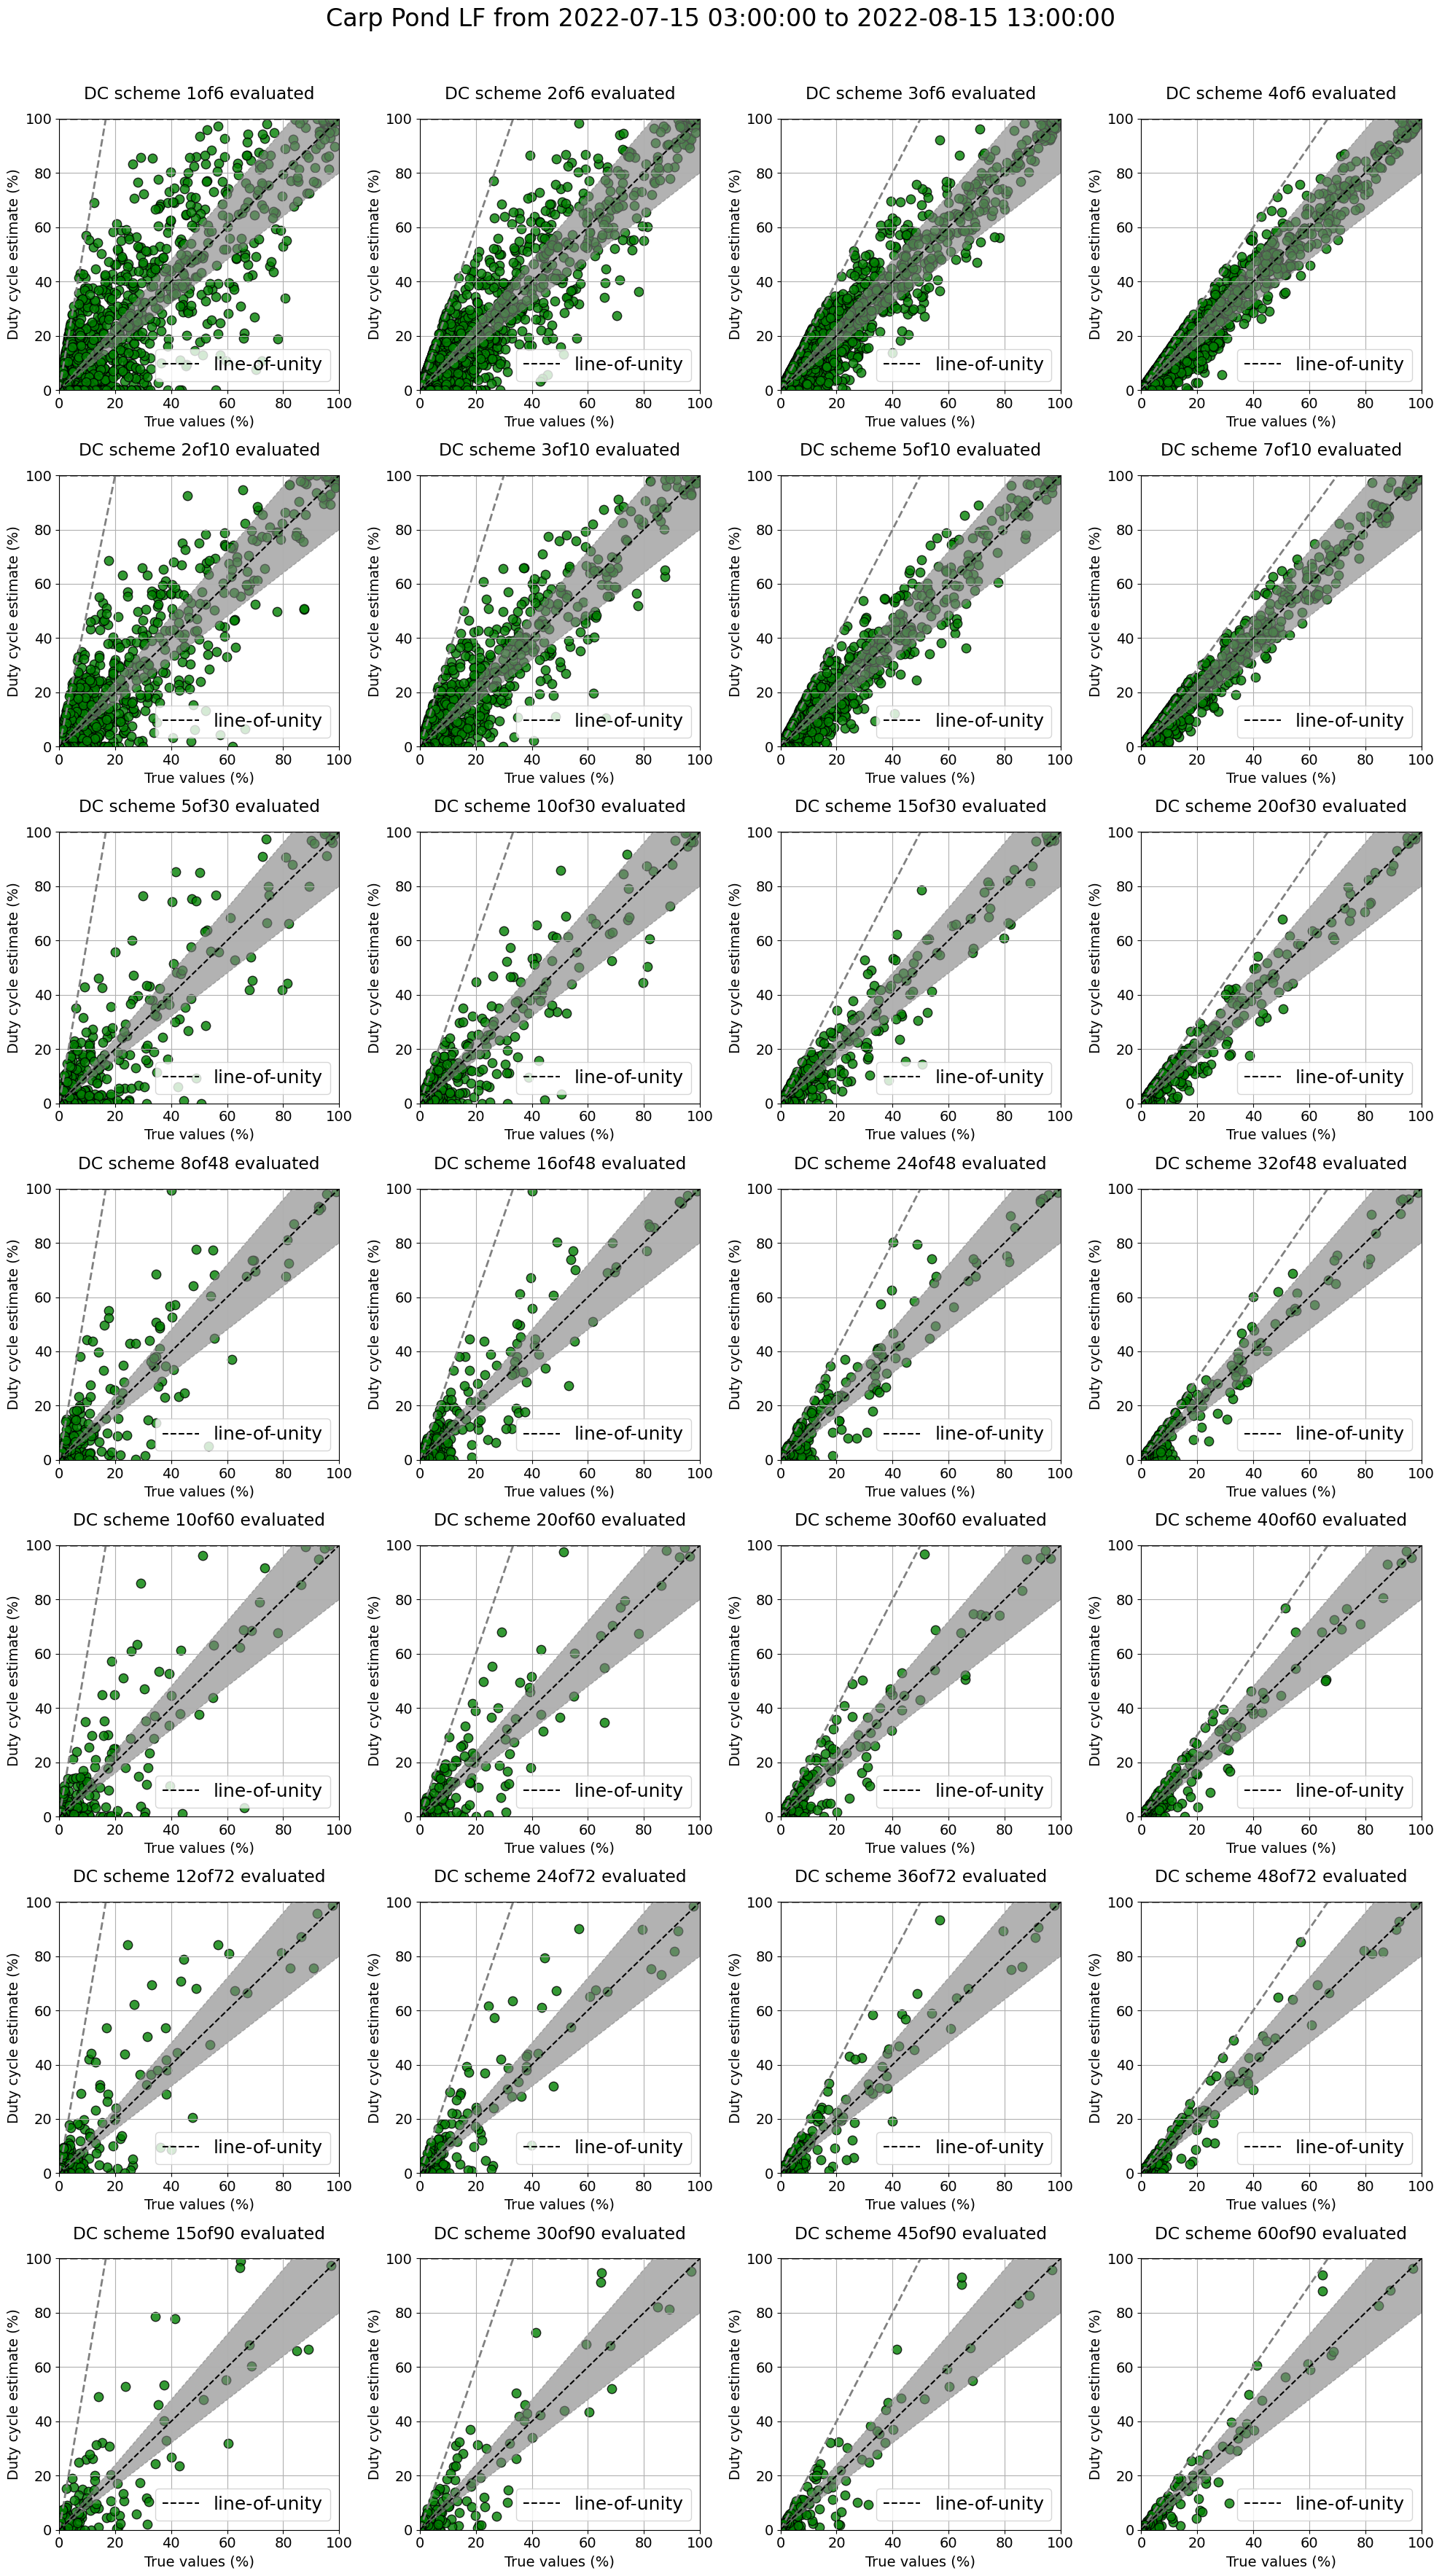

In [14]:
data_params['metric_tag'] = 'bout_time_percentage'
data_params['index_time_block_in_secs'] = '5'
csv_mtag = metric_to_tags[data_params['metric_tag']]
activty_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_dc.index = pd.DatetimeIndex(activty_arr_dc.index)
activty_arr_cont.index = pd.DatetimeIndex(activty_arr_cont.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')
data_params['P'] = 0.20

plot_all_dc_scheme_comps_linear_scale(activty_arr_dc, activty_arr_cont, data_params)

In [15]:
def plot_all_dc_scheme_curves(activty_arr_dc, activty_arr_cont, data_params):
    plt.figure(figsize=(5*len(data_params['percent_ons']), 5*len(data_params['cycle_lengths'])))
    plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
                    y=1.01, fontsize=24)
    plt.rcParams.update({'font.size':14})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(activty_arr_dc.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(activty_arr_cont.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

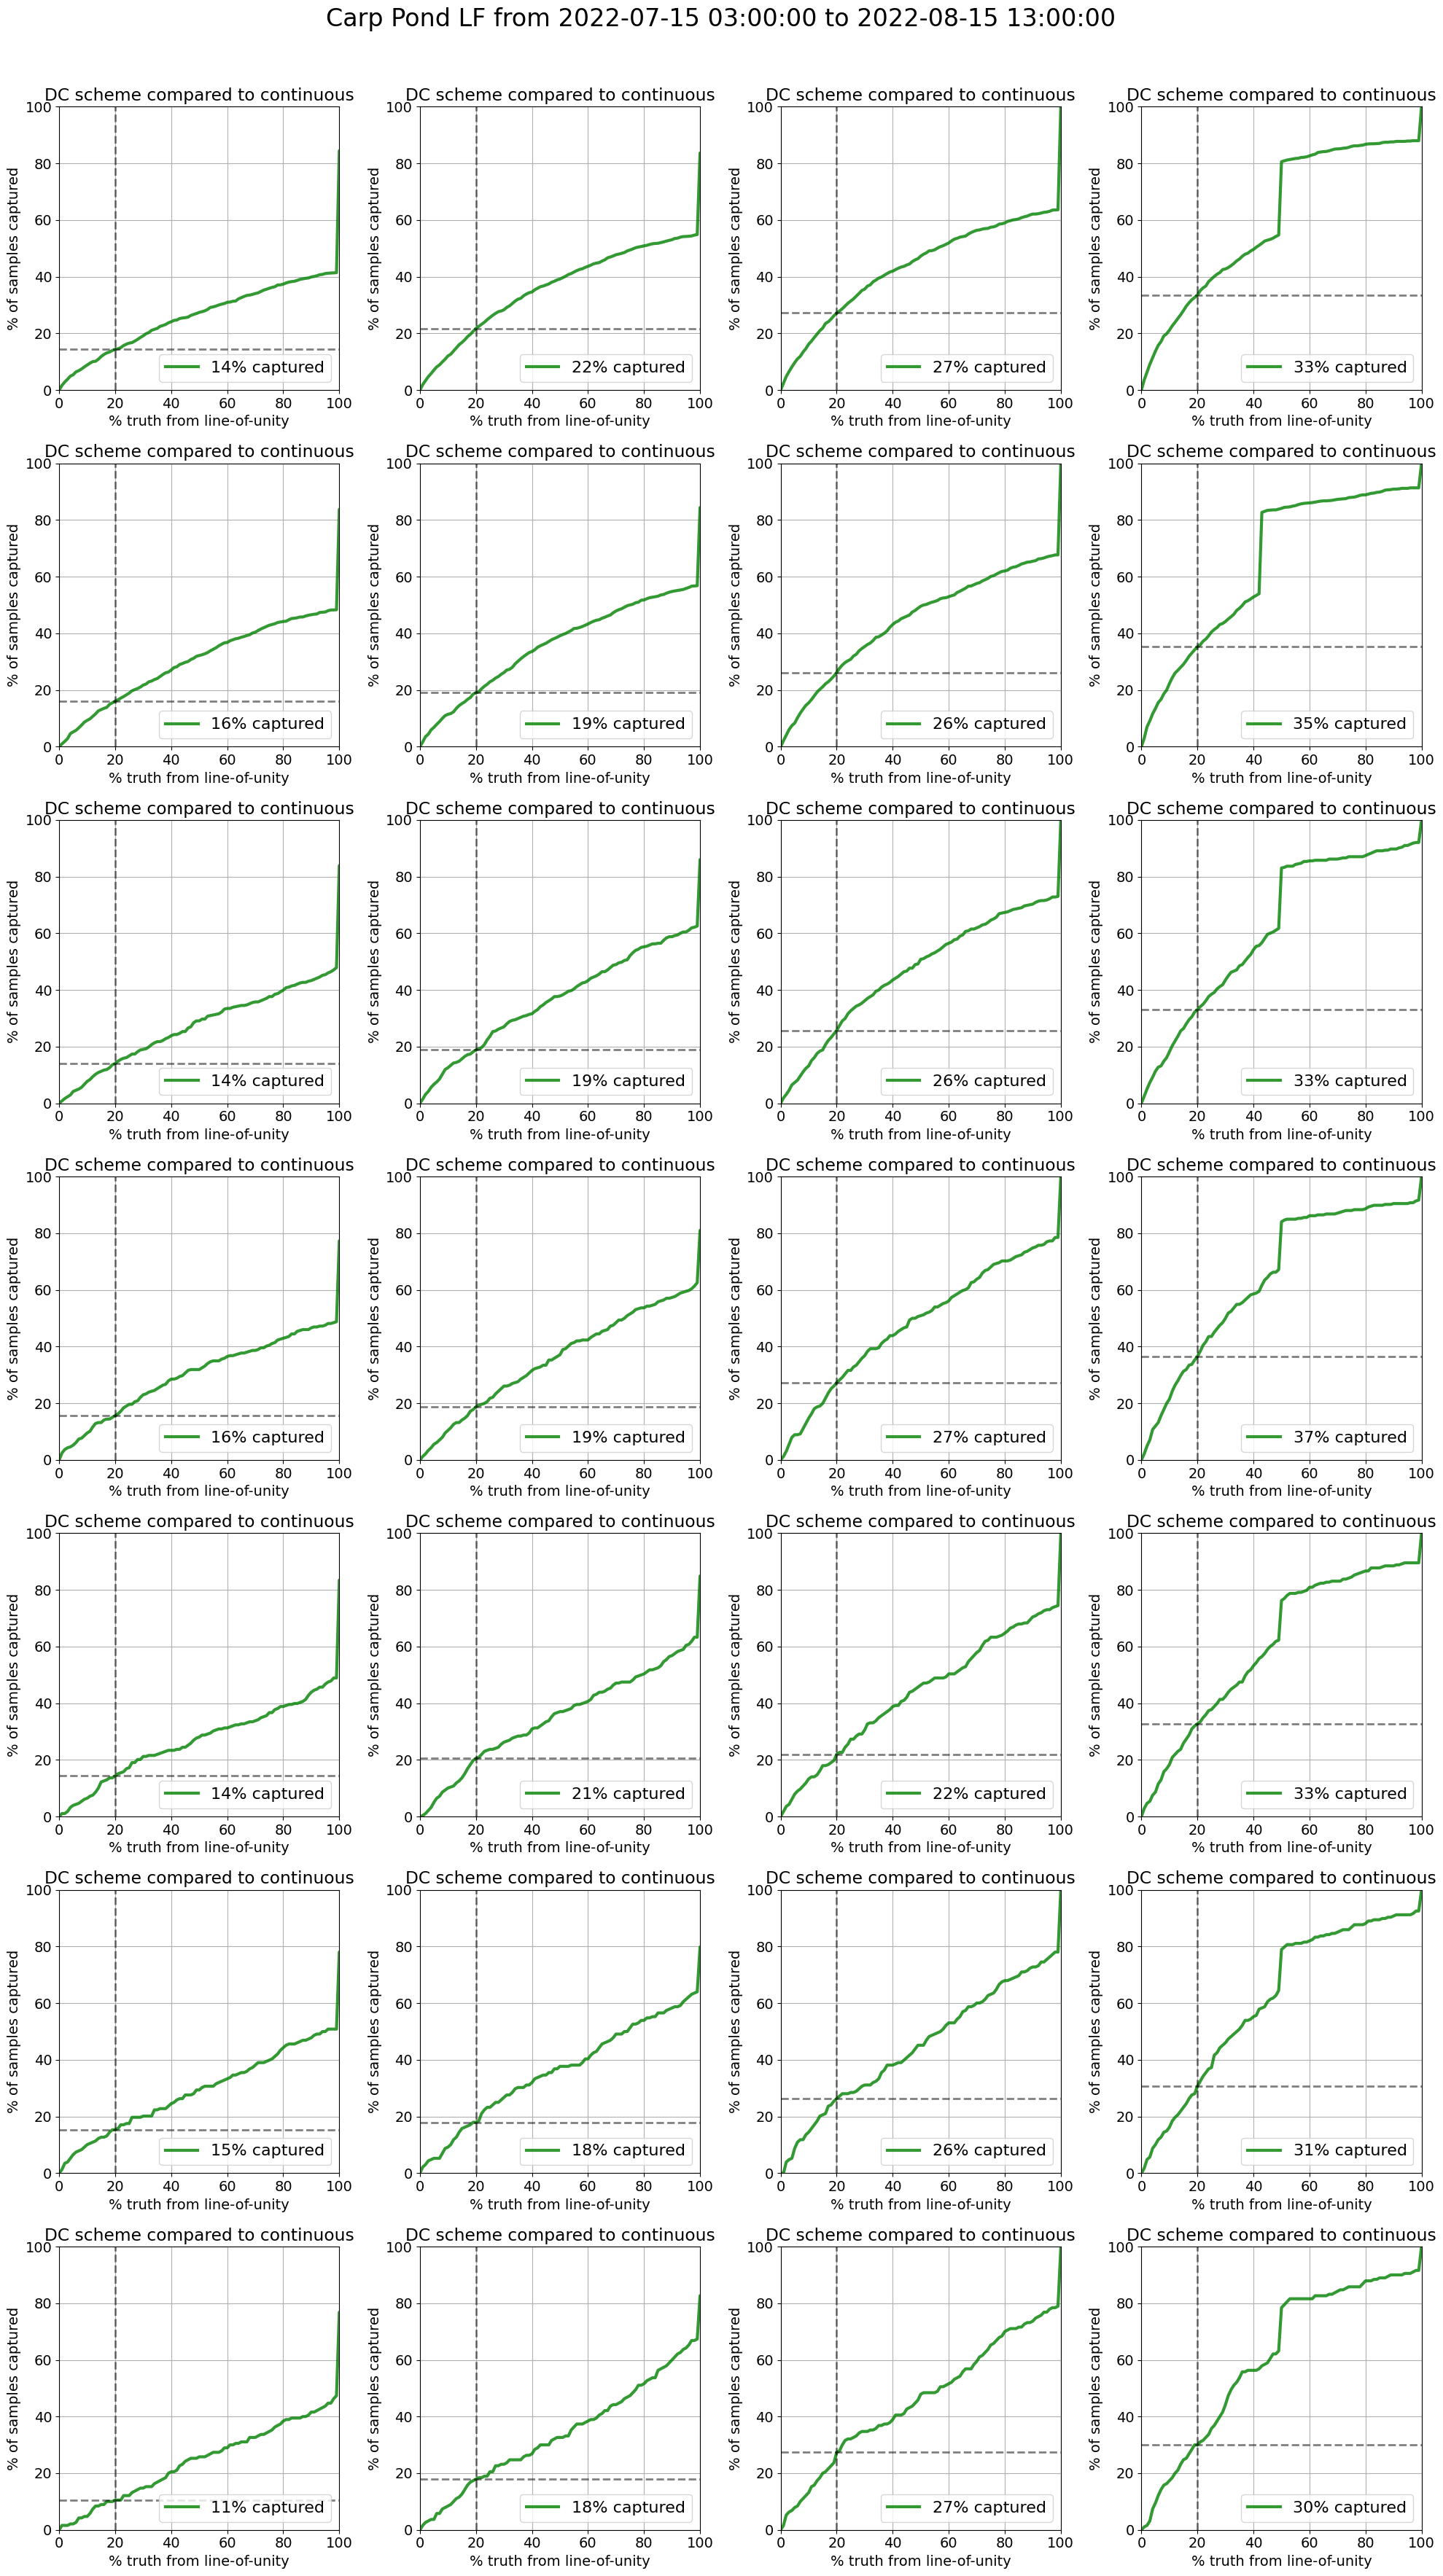

In [16]:
data_params['metric_tag'] = 'bout_time_percentage'
data_params['index_time_block_in_secs'] = '5'
csv_mtag = metric_to_tags[data_params['metric_tag']]
activty_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_dc.index = pd.DatetimeIndex(activty_arr_dc.index)
activty_arr_cont.index = pd.DatetimeIndex(activty_arr_cont.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')
data_params['P'] = 0.20

plot_all_dc_scheme_curves(activty_arr_dc, activty_arr_cont, data_params)

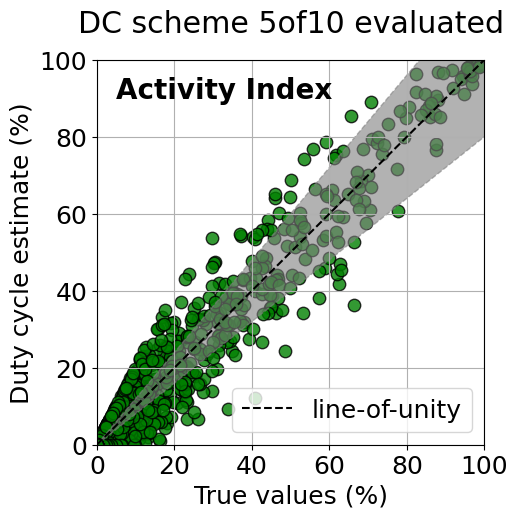

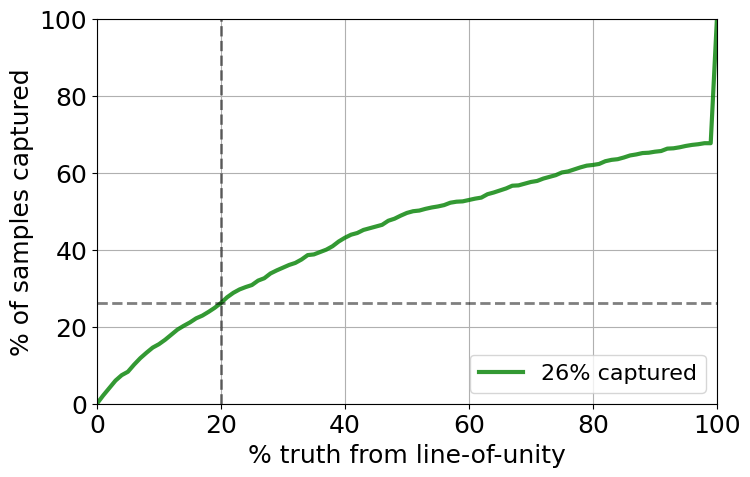

In [17]:
dc_col = '5of10'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
on = int(dc_col.split('of')[0])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(activty_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(activty_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)

plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size':18})
plt.title(f'Duty-cycle scheme ({on}min ON every {cycle_length}min) compared to continuous', y=1.1)
plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params, hide_bounds=True)
plt.text(x=5, y=90, s='Activity Index', fontweight='bold', fontsize=20)

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)
plt.title('')
plt.show()

In [18]:
def compare_two_dc_schemes_for_metric(activity_arr_cont, activity_arr_dc, dc_col1, dc_col2, data_params):
    metric_col_name = f'{data_params["metric_tag"]} ({dc_col1})'
    cycle_length = int(dc_col1.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activity_arr_dc.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(activity_arr_cont.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)

    if data_params['metric_tag']=='call_rate':
        col = 'red'
    elif data_params['metric_tag']=='activity_index':
        col = 'royalblue'
    else:
        col = 'green'

    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    p = np.arange(0, 10, 0.01) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb)
    plt.plot(100*p, 100*percent_points_in_bounds, color=col, linewidth=4, alpha=0.8, label=f'{on}min ON every {total}min')

    metric_col_name = f'{data_params["metric_tag"]} ({dc_col2})'
    cycle_length = int(dc_col2.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activity_arr_dc.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(activity_arr_cont.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    p = np.arange(0, 10, 0.01) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb)


    plt.plot(100*p, 100*percent_points_in_bounds, linestyle='dashed', color=col, linewidth=4, alpha=0.8, label=f'{on}min ON every {total}min')
    plt.xlabel('% truth from line-of-unity')
    plt.xlim(-5, 105)
    plt.ylim(-5, 105)
    plt.ylabel('% of samples captured')
    plt.legend(loc=4, fontsize=16)
    plt.grid(which='both')

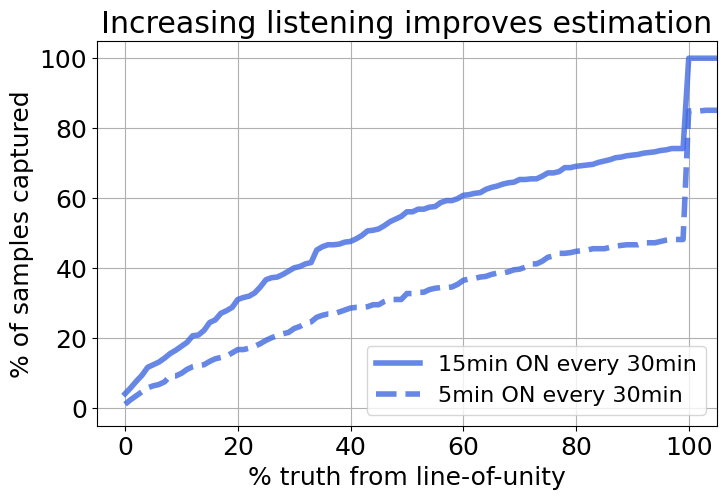

In [19]:
data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
csv_mtag = metric_to_tags[data_params['metric_tag']]
activty_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_dc.index = pd.DatetimeIndex(activty_arr_dc.index)
activty_arr_cont.index = pd.DatetimeIndex(activty_arr_cont.index)
data_params['P'] = 0.20
dc_col1 = '15of30'
dc_col2 = '5of30'

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plt.title(f'Increasing listening improves estimation')
compare_two_dc_schemes_for_metric(activty_arr_cont, activty_arr_dc, dc_col1, dc_col2, data_params)
plt.show()

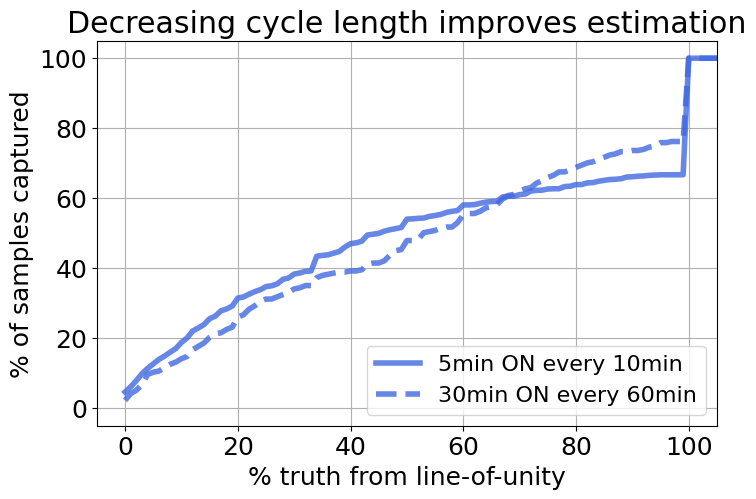

In [20]:
data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
csv_mtag = metric_to_tags[data_params['metric_tag']]
activty_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_dc.index = pd.DatetimeIndex(activty_arr_dc.index)
activty_arr_cont.index = pd.DatetimeIndex(activty_arr_cont.index)
data_params['P'] = 0.20
dc_col1 = '5of10'
dc_col2 = '30of60'

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plt.title(f'Decreasing cycle length improves estimation')
compare_two_dc_schemes_for_metric(activty_arr_cont, activty_arr_dc, dc_col1, dc_col2, data_params)
plt.show()

In [21]:
def compare_high_low_activity_for_metric(activity_arr_cont, activity_arr_dc, dc_col, data_params):
    metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
    cycle_length = int(dc_col.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activity_arr_dc.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(activity_arr_cont.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)

    if data_params['metric_tag']=='call_rate':
        thresh = 50
        col = 'red'
        mtag = 'CR'
    elif data_params['metric_tag']=='activity_index':
        thresh = 50
        col = 'royalblue'
        mtag = 'AI'
    else:
        thresh = 50
        col = 'green'
        mtag = 'BTP'

    high_cmetr = plt_cmetr[plt_cmetr>=thresh].dropna()
    low_cmetr = plt_cmetr[plt_cmetr<thresh].dropna()
    high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
    low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    p = np.arange(0, 10, 0.01) + 1e-14
    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
    plt.plot(100*p, 100*percent_points_in_bounds, color=col, linewidth=4, alpha=0.8, label=f'More than 50% {data_params["metric_tag"]}')
    percent_points_in_bounds = get_percent_points_in_bounds_log(low_dcmetr, low_cmetr, p, upb)

    plt.plot(100*p, 100*percent_points_in_bounds, linestyle='dashed', color=col, linewidth=4, alpha=0.8, label=f'Less than 50% {data_params["metric_tag"]}')
    plt.xlabel('% truth from line-of-unity')
    plt.xlim(-5, 105)
    plt.ylim(-5, 105)
    plt.ylabel('% of samples captured')
    plt.legend(loc=4, fontsize=16)
    plt.grid(which='both')

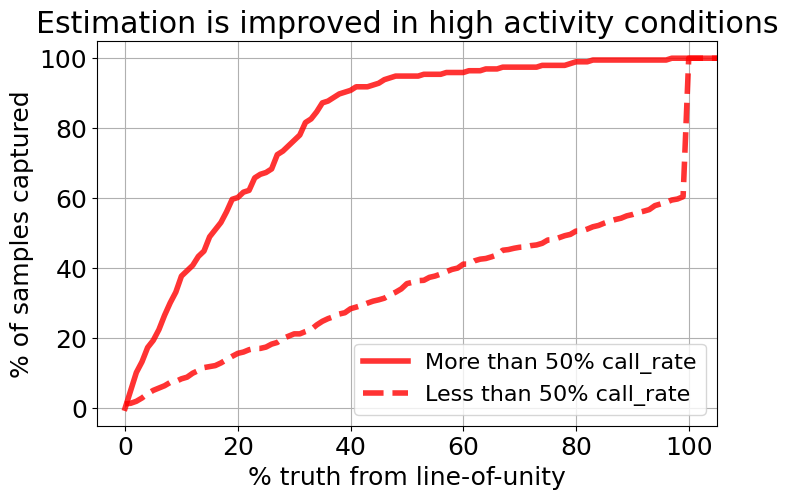

In [22]:
data_params['metric_tag'] = 'call_rate'
data_params['index_time_block_in_secs'] = '5'
csv_mtag = metric_to_tags[data_params['metric_tag']]
activty_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
activty_arr_dc.index = pd.DatetimeIndex(activty_arr_dc.index)
activty_arr_cont.index = pd.DatetimeIndex(activty_arr_cont.index)
data_params['P'] = 0.20
dc_col = '5of10'

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plt.title(f'Estimation is improved in high activity conditions')
compare_high_low_activity_for_metric(activty_arr_cont, activty_arr_dc, dc_col, data_params)
plt.show()

In [23]:
def plot_dc_scheme_eval_for_all_metrics(file_paths, dc_col, data_params):
    plt_linewidth = 3
    p = np.arange(0, 10, 0.01) + 1e-14
    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]

    for metric in ['call_rate', 'bout_time_percentage', 'activity_index']:
        data_params['metric_tag'] = metric
        csv_mtag = metric_to_tags[data_params['metric_tag']]
        activity_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"dc_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
        activity_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths[f"cont_{csv_mtag}_TYPE_SITE_summary"]}.csv', index_col=0)
        activity_arr_dc.index = pd.DatetimeIndex(activity_arr_dc.index)
        activity_arr_cont.index = pd.DatetimeIndex(activity_arr_cont.index)

        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(activity_arr_dc.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(activity_arr_cont.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)

        dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
        total = int(dc_tag_split[-1])
        on = int(dc_tag_split[0])
        listening_ratio = on/total
        upper_bound_line = (1/listening_ratio)-1
        if data_params['upb']!=1:
            upb = upper_bound_line
        else:
            upb = data_params['upb']

        if data_params['metric_tag']=='call_rate':
            thresh = 10
            col = 'red'
            mtag = 'CR'
        elif data_params['metric_tag']=='activity_index':
            thresh = 10
            col = 'royalblue'
            mtag = 'AI'
        else:
            thresh = 10
            col = 'green'
            mtag = 'BTP'

        high_cmetr = plt_cmetr[plt_cmetr>=thresh].dropna()
        low_cmetr = plt_cmetr[plt_cmetr<thresh].dropna()
        high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
        low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

        percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb)
        points_on_line = percent_points_in_bounds[p_inds]
        plt.plot(100*p, 100*percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                    color=col, linestyle='solid', linewidth=plt_linewidth, alpha=0.2)
        
        percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
        points_on_line = percent_points_in_bounds[p_inds]
        plt.plot(100*p, 100*percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                    color=col, linestyle='solid', linewidth=plt_linewidth, alpha=0.8)
        
        percent_points_in_bounds = get_percent_points_in_bounds_log(low_dcmetr, low_cmetr, p, upb)
        points_on_line = percent_points_in_bounds[p_inds]
        plt.plot(100*p, 100*percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                    color=col, linestyle='dashed', linewidth=plt_linewidth, alpha=0.8)

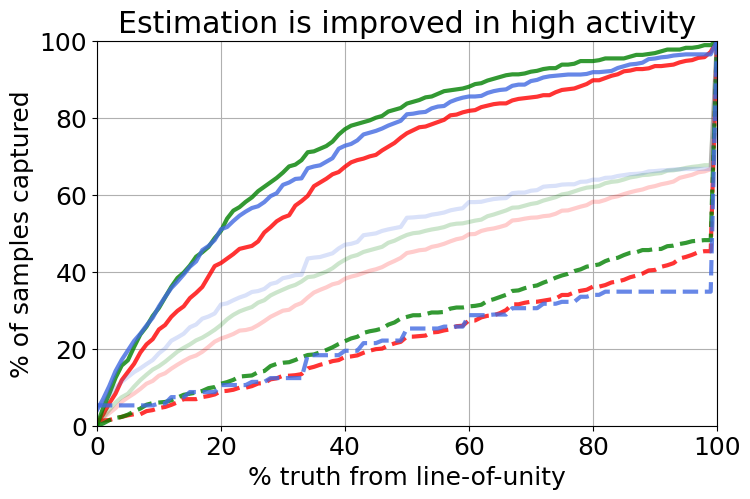

In [24]:
data_params['index_time_block_in_secs'] = '5'
data_params['P'] = 0.20

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})

dc_col = '5of10'
plt.title(f'Estimation is improved in high activity')
plot_dc_scheme_eval_for_all_metrics(file_paths, dc_col, data_params)
plt.xlabel('% truth from line-of-unity')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('% of samples captured')
# plt.legend(loc=(1.04, 0), fontsize=16)
plt.grid(which='both')

plt.show()